In [1]:
import uproot
import numpy as np
import awkward as ak
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
# Load signal sample into memory
with uproot.open("ntuples/dataset_mu60_ztt1000_10k.root:fastjet") as f:
    jet_pt_sig = f["jet_pt"].array()
    jet_eta_sig = f["jet_eta"].array()
    jet_phi_sig = f["jet_phi"].array()
    jet_m_sig = f["jet_m"].array()
    jet_pufr_sig = f["jet_pufr_truth"].array()
    jet_idx_sig = f["jet_ttbar_match"].array()
    jet_label_sig = np.ones(len(jet_pt_sig))

# Load background sample into memory
with uproot.open("ntuples/dataset_mu60_ttbar_10k.root:fastjet") as f:
    jet_pt_bkg = f["jet_pt"].array()
    jet_eta_bkg = f["jet_eta"].array()
    jet_phi_bkg = f["jet_phi"].array()
    jet_m_bkg = f["jet_m"].array()
    jet_pufr_bkg = f["jet_pufr_truth"].array()
    jet_idx_bkg = f["jet_ttbar_match"].array()
    jet_label_bkg = np.zeros(len(jet_pt_bkg))

In [3]:
# crazy vectorized syntax https://awkward-array.org/doc/main/user-guide/how-to-restructure-concatenate.html#emulating-numpy-s-stack-functions
jet_sig = ak.concatenate([jet_pt_sig[:, :, np.newaxis], jet_eta_sig[:, :, np.newaxis], jet_phi_sig[:, :, np.newaxis], jet_m_sig[:, :, np.newaxis], jet_pufr_sig[:, :, np.newaxis]], axis=2)
jet_bkg = ak.concatenate([jet_pt_bkg[:, :, np.newaxis], jet_eta_bkg[:, :, np.newaxis], jet_phi_bkg[:, :, np.newaxis], jet_m_bkg[:, :, np.newaxis], jet_pufr_bkg[:, :, np.newaxis]], axis=2)

# combine sig and bkg into one vector
jet_feats = ak.concatenate([jet_sig, jet_bkg], axis=0)
jet_labels = np.concatenate([jet_label_sig,jet_label_bkg], axis=0)
jet_idx = np.array(ak.concatenate([jet_idx_sig, jet_idx_bkg], axis=0))

In [13]:
shuffled_idx = np.random.permutation(len(jet_feats))
jet_feats = jet_feats[shuffled_idx]
jet_labels = jet_labels[shuffled_idx]

sig = (jet_labels==1)    
bkg = ~sig

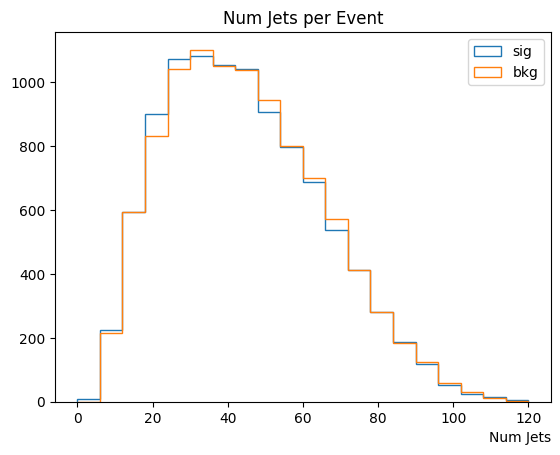

In [22]:
h_num_jets = ak.num(jet_feats,axis=1)
plt.title('Num Jets per Event')
plt.hist(h_num_jets[sig],histtype='step',label='sig',bins=20,range=(0,120))
plt.hist(h_num_jets[bkg],histtype='step',label='bkg',bins=20,range=(0,120))
plt.xlabel('Num Jets',loc='right')
plt.legend()
plt.show()

In [35]:
print(len(jet_feats))
means = ak.mean(jet_feats,axis=0)
print(means)
print(len(means))
print(len(means[0]))

20000
[[208, 0.01, 3.14, 49.9, 0.0298], [161, ...], ..., [25.5, -3, 3.76, 13.6, 1]]
121
5


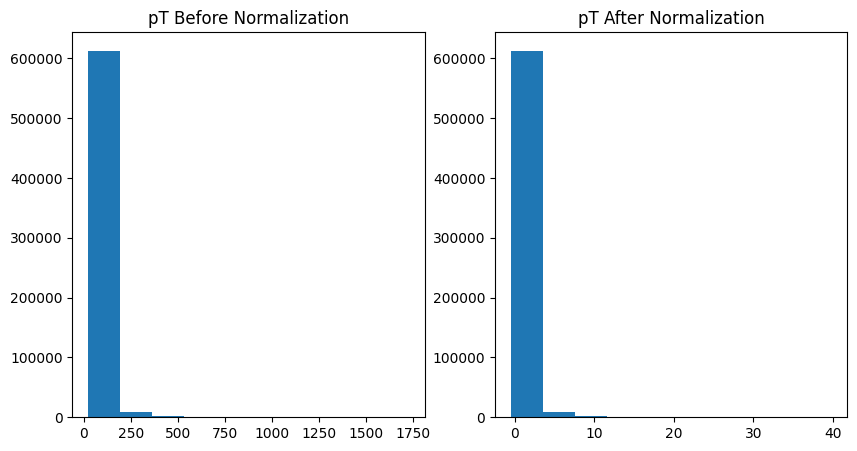

Before Mean:  44.90622393594498
Before STD:  42.30069565625325
After Mean:  -0.00023473729744751085
After STD:  1.0002322502211343


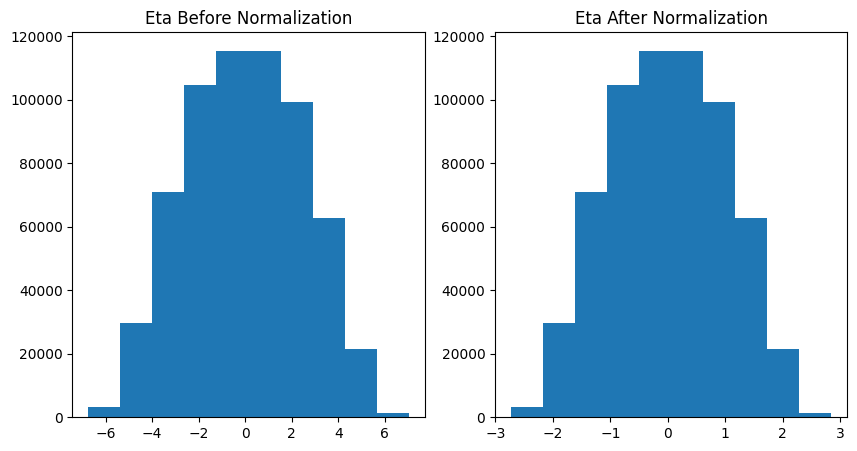

Before Mean:  0.00017780822172007424
Before STD:  2.469346230124567
After Mean:  1.3512981668506497e-08
After STD:  1.000096154586018


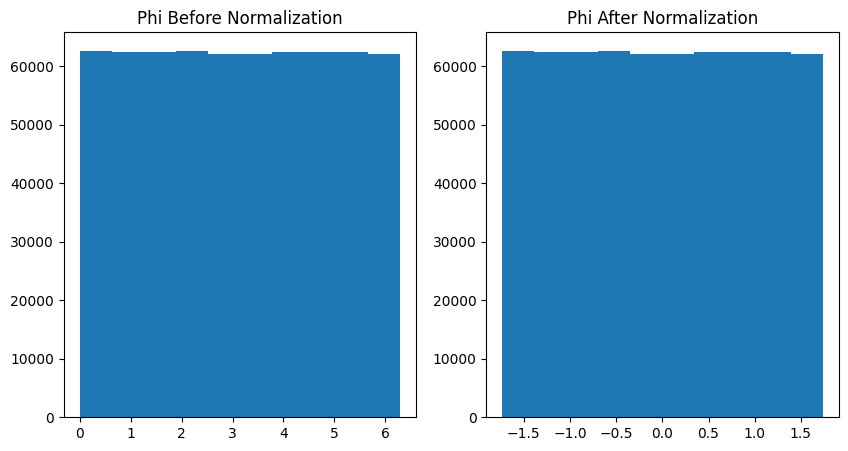

Before Mean:  3.13848193319903
Before STD:  1.813240326306129
After Mean:  9.161236501445973e-06
After STD:  1.0002891649733614


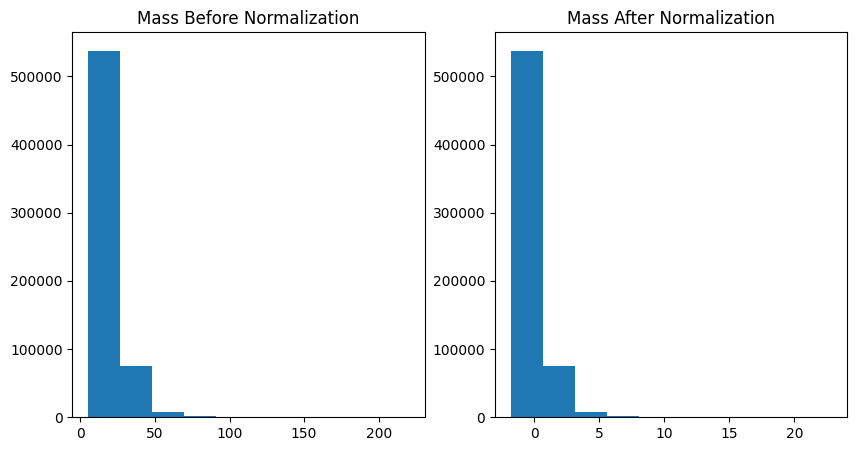

Before Mean:  20.962418038571595
Before STD:  8.715959079942785
After Mean:  -3.914741905982839e-06
After STD:  0.9999423294293572


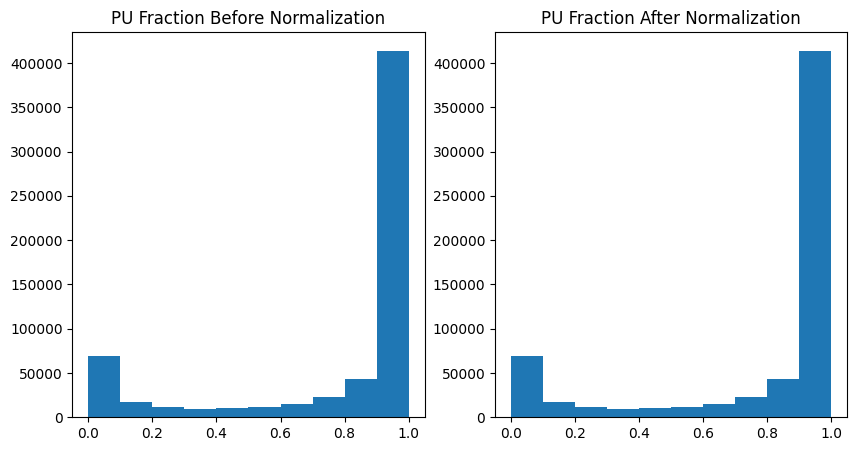

Before Mean:  0.7908265352931364
Before STD:  0.33630447013143233
After Mean:  0.7908037014657644
After STD:  0.33656684162840306


/home/lvaughan/VirtualEnvs/torch/lib/python3.10/site-packages/torch/nested/__init__.py:220: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  return _nested.nested_tensor(


In [77]:
# Split dataset into train, val, test split
data = jet_feats
labels = jet_labels
num_events = len(data)
X_train_raw = data[0:int(0.7*num_events)]
y_train = labels[0:int(0.7*num_events)].reshape(-1,1)
X_val_raw = data[int(0.7*num_events):int(0.75*num_events)]
y_val = labels[int(0.7*num_events):int(0.75*num_events)].reshape(-1,1)
X_test_raw = data[int(0.75*num_events):]
y_test = labels[int(0.75*num_events):].reshape(-1,1)

# Calculate the mean and std of each feature
num_feats = len(jet_feats[0][0])
X_train_means = []
X_train_stds = []
for i in range(num_feats):
    X_train_means.append(ak.mean(X_train_raw[:,:,i]))
    X_train_stds.append(ak.std(X_train_raw[:,:,i]))
# Do not apply mean and std to pufr
X_train_means[-1]=0
X_train_stds[-1]=1

# Normalize dataset
norm_data  =[]
for i in range(num_feats):
    norms = ak.Array((X_train_raw[:,:,i] - X_train_means[i]) / X_train_stds[i])
    norm_data.append(norms)
norm_list = []
for i in range(num_feats):
    norm_list.append(norm_data[i][:, :, np.newaxis])
X_train_norm = ak.concatenate(norm_list, axis=2)
        
# Validation plots
var_list = ['pT','Eta','Phi','Mass','PU Fraction']
for i in range(len(var_list)):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    var1 = ak.flatten(X_train_raw[:,:,i])
    ax1.hist(var1)
    ax1.set_title(var_list[i]+" Before Normalization")
    var2 = ak.flatten(X_train_norm[:,:,i])
    ax2.hist(var2)
    ax2.set_title(var_list[i]+" After Normalization")
    plt.show()
    print("Before Mean: ", np.mean(var1))
    print("Before STD: ", np.std(var1))
    print("After Mean: ", np.mean(var2))
    print("After STD: ", np.std(var2))

# Convert to torch.Tensor()
X_train = torch.nested.nested_tensor(ak.to_list(X_train_norm))
y_train = torch.Tensor(y_train)
X_val = torch.nested.nested_tensor(ak.to_list(X_val_norm))
y_val = torch.Tensor(y_val)
X_test = torch.nested.nested_tensor(ak.to_list(X_test_norm))
y_test = torch.Tensor(y_test)

In [78]:
class Model(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats):
        super(Model, self).__init__()        
        self.jet_preprocess = nn.Linear(in_feats,hidden_feats)
        self.jet_postprocess = nn.Linear(hidden_feats,out_feats)
    def forward(self, jet_feats):
        jet_embedding = F.relu(self.jet_preprocess(jet_feats))
        jet_aggregated = jet_embedding.sum(dim=1)
        output = F.sigmoid(self.jet_postprocess(jet_aggregated))
        return output

In [ ]:
def train(model, data, epochs=20):
    X_train, y_train, X_val, y_val = data
    
    history = {'train_loss':[],'test_loss':[]}

    for i in range(epochs):
        for j in range(num_train):
            optimizer.zero_grad()
            outputs = model(X_train.to(device))
            loss = loss_fn(outputs, y_train.to(device))
            loss.backward()
            optimizer.step()
            
        for j in range(num_val):
            model.eval()
            train_loss = loss.detach().cpu().numpy()
            history['train_loss'].append(train_loss)
            y_pred = model(X_val.to(device))
            test_loss = loss_fn(y_pred,y_val.to(device)).detach().cpu().numpy()
            history['test_loss'].append(test_loss)

        if (e+1)%100==0:
            print('Epoch:',e+1,'\tTrain Loss:',round(float(loss),4),'\tTest Loss:',round(float(test_loss),4))

    return history   

In [ ]:
print("GPU Available: ", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
# Use BinaryCrossEntropy for binary classification
loss_fn = nn.BCELoss()

# Train baseline model with pt,eta,phi,m
print("Training Baseline")
baseline = Model(4,256,1).to(device)
optimizer = optim.Adam(baseline.parameters(), lr=0.0001)
data = [X_train[:,:,0:4], y_train, X_val[:,:,0:4], y_val]
baseline_history = train(baseline, data, epochs=1000)
print()

# Train upgraded model with pt,eta,phi,m,pufr
print("Training Proposed")
model = Model(5,256,1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
data = [X_train, y_train, X_val, y_val]
model_history = train(model, data, epochs=1000)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(baseline_history['train_loss'],label='train')
ax1.plot(baseline_history['test_loss'],label='test')
ax1.set_title("Baseline Loss")
ax1.legend()
ax2.plot(model_history['train_loss'],label='train')
ax2.plot(model_history['test_loss'],label='test')
ax2.set_title("Proposed Loss")
ax2.legend()
plt.show()

In [ ]:
fig, (ax1) = plt.subplots(1, 1, figsize=(10, 6))
                             
baseline.to('cpu')
y_pred = baseline(X_test[:,:,0:4]).detach()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
ax1.plot(fpr,tpr, label="baseline")
ax1.plot([[0,0],[1,1]],'--',color='k')
AUC = "Baseline ROC AUC: " + str(round(roc_auc_score(y_test, y_pred),4))
ax1.text(0.5,0.2,AUC)

model.to('cpu')
y_pred = model(X_test).detach()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
ax1.plot(fpr,tpr, label="proposed")
ax1.plot([[0,0],[1,1]],'--',color='k')
ax1.set_title("ROC Curve")
AUC = "Proposed ROC AUC: " + str(round(roc_auc_score(y_test, y_pred),4))
ax1.text(0.5,0.1,AUC)
ax1.legend()
plt.show()